# Setup

In [1]:
# Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

#from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.tree import export_graphviz
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
import joblib                                              # running computationally intensive tasks in parallel
import seaborn as sns

# Load Data

In [5]:
# Load Preprocessed Data
data_dir = 'data/'

# Load Data
df1_final = pd.read_csv(data_dir + 'df1_final.csv')
df2_final = pd.read_csv(data_dir + 'df2_final.csv')
df3_final = pd.read_csv(data_dir + 'df3_final.csv')
df4_final = pd.read_csv(data_dir + 'df4_final.csv')

# Drop Index Column
df1_final = df1_final.drop(df1_final.columns[0], axis=1)
df2_final = df2_final.drop(df2_final.columns[0], axis=1)
df3_final = df3_final.drop(df3_final.columns[0], axis=1)
df4_final = df4_final.drop(df4_final.columns[0], axis=1)


In [6]:
# Preview data
df1_final.head(3)

,wave,nkids,pinc_decile,hhincnet_decile,edu,health,bmi_category,val1i3,val1i4,val1i5,...,ethni_Other.non.German.background,ethni_Turkish.background,region_Eastern.Germany,region_Western.Germany,addchild_Unsure,addchild_Yes,denomination_None,denomination_Other,denomination_Protestant,denomination_Roman.Catholic
0,11,1,7,8,3,5,2,2,2,2,...,0,0,0,1,0,1,0,0,1,0
1,11,1,10,7,3,5,2,3,2,3,...,0,0,0,1,0,1,0,0,1,0
2,13,1,5,2,2,4,3,3,1,2,...,0,0,1,0,0,1,1,0,0,0


In [36]:
# Data-types of each df1_final column
pd.DataFrame(df1_final.dtypes, columns=['dtypes'])

,dtypes
wave,int64
nkids,int64
pinc_decile,int64
hhincnet_decile,int64
edu,int64
health,int64
bmi_category,int64
val1i3,int64
val1i4,int64
val1i5,int64


# Split Data

In [8]:
# Import necessary libraries
from sklearn.model_selection import train_test_split

# List of cleaned DataFrames
dfs_final = [df1_final, df2_final, df3_final, df4_final]

# Initialize lists to store train/test splits
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

# Loop through each DataFrame and perform the train/test split
for df in dfs_final:
    X = df.drop(['hormon_iudor'], axis=1)
    y = df['hormon_iudor']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

# Access the splits for each DataFrame
X1_train, X1_test, y1_train, y1_test = X_train_list[0], X_test_list[0], y_train_list[0], y_test_list[0]
X2_train, X2_test, y2_train, y2_test = X_train_list[1], X_test_list[1], y_train_list[1], y_test_list[1]
X3_train, X3_test, y3_train, y3_test = X_train_list[2], X_test_list[2], y_train_list[2], y_test_list[2]
X4_train, X4_test, y4_train, y4_test = X_train_list[3], X_test_list[3], y_train_list[3], y_test_list[3]

In [7]:
# Check Class Imbalance of Target Variable
print(y1_train.value_counts())
print(y2_train.value_counts())
print(y3_train.value_counts())
print(y4_train.value_counts())

hormon_iudor
1    325
0    204
Name: count, dtype: int64
hormon_iudor
1    416
0    100
Name: count, dtype: int64
hormon_iudor
0    260
1    164
Name: count, dtype: int64
hormon_iudor
1    274
0    256
Name: count, dtype: int64


# Fit Models

In [9]:
# Import Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

## Decision Trees

In [29]:
# Set Parameters Values
max_depth_full=list(range(5,21))
min_samples_split_full = list(range(2,41))

In [30]:
# Hyperparmeter Tuning - Random Search

model_dt = DecisionTreeClassifier(random_state=666)
distributions = dict(max_depth = max_depth_full, 
                     min_samples_split = min_samples_split_full)

clf_dt = RandomizedSearchCV(model_dt, distributions, n_iter=100, verbose=2,
                            scoring='f1',  # Use an appropriate scoring metric for classification
                            refit='f1',    # Refit the model using the best scoring metric
                            cv=5, 
                            random_state=666)

# Fit the model to Search
search = clf_dt.fit(X1_train, y1_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END .................max_depth=13, min_samples_split=34; total time=   0.0s
[CV] END .................max_depth=13, min_samples_split=34; total time=   0.0s
[CV] END .................max_depth=13, min_samples_split=34; total time=   0.0s
[CV] END .................max_depth=13, min_samples_split=34; total time=   0.0s
[CV] END .................max_depth=13, min_samples_split=34; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=28; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=28; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=28; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=28; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=28; total time=   0.0s
[CV] END ..................max_depth=7, min_samples_split=13; total time=   0.0s
[CV] END ..................max_depth=7, min_sa

In [31]:
# Select Best parameters
best_params = search.best_params_

print(f"Best parameters found: {search.best_params_}")
print(f"Best F1 score: {search.best_score_}")

Best parameters found: {'min_samples_split': 25, 'max_depth': 5}
Best F1 score: 0.7004470575112519


In [12]:
# Fit Final Model with Tuned Hyperparameters
best_params = search.best_params_
dt_final1 = DecisionTreeClassifier(**best_params, random_state=666)

# Fit the model
dt_final1.fit(X1_train, y1_train)

# Predict on the test set
pred_test_dt1 = dt_final1.predict(X1_test)

# Evaluate the model using appropriate classification metrics
print(f"Accuracy: {accuracy_score(y1_test, pred_test_dt1)}")
print(f"F1 Score: {f1_score(y1_test, pred_test_dt1)}")
print(f"ROC AUC Score: {roc_auc_score(y1_test, pred_test_dt1)}")

Accuracy: 0.5714285714285714
F1 Score: 0.6984126984126984
ROC AUC Score: 0.5103141115799343


## Random Forest

### Hyperparmeter: Random Search

In [10]:
# Set Hyperparameters Range
n_estimators_full=[10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000] # Number of trees in the forest.
#n_estimators_full=[10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

max_depth_full=list(range(2,26)) # Maximum depth of each tree.
#max_depth_full=list(range(2,21))

min_samples_split_full = list(range(2,41)) # Minimum number of samples required to split an internal node.
#min_samples_split_full = list(range(2,41))

In [49]:
# Set Hyperparameters Range
distributions = dict(
    n_estimators=[100, 200, 400, 600, 800, 1000],
    max_depth=[None, 10, 20, 30, 40, 50],
    min_samples_split=[2, 5, 10, 14, 20],
    min_samples_leaf=[1, 2, 4, 6, 8],
    class_weight = ['balanced'], # Include class_weight in the search space
    max_features=['sqrt', 'log2']  # Include max_features in the search space
)

In [68]:
# Hyperparmeter Tuning - Random Search
model_rf = RandomForestClassifier(random_state=666)

# Set up the RandomizedSearchCV
clf_rf = RandomizedSearchCV(model_rf, distributions,
                            n_iter=200,
                            verbose=2,
                            n_jobs=4,
                            scoring='roc_auc',  # Use an appropriate scoring metric for classification
                            refit='roc_auc',    # Refit the model using the best scoring metric
                            cv=7,
                            random_state=666)

# Fit the search
random_searchX1 = clf_rf.fit(X1_train, y1_train)
joblib.dump(random_searchX1, 'random_searchX1.pkl')
print(f"Best parameters from the Random Search: {random_searchX1.best_params_}")
print(f"Best ROC-AUC score from the Random Search: {random_searchX1.best_score_}")

random_searchX2 = clf_rf.fit(X2_train, y2_train)
joblib.dump(random_searchX2, 'random_searchX2.pkl')
print(f"Best parameters from the Random Search: {random_searchX2.best_params_}")
print(f"Best ROC-AUC score from the Random Search: {random_searchX2.best_score_}")

random_searchX3 = clf_rf.fit(X3_train, y3_train)
joblib.dump(random_searchX3, 'random_searchX3.pkl')
print(f"Best parameters from the Random Search: {random_searchX3.best_params_}")
print(f"Best ROC-AUC score from the Random Search: {random_searchX3.best_score_}")

random_searchX4 = clf_rf.fit(X4_train, y4_train)
joblib.dump(random_searchX4, 'random_searchX4.pkl')
print(f"Best parameters from the Random Search: {random_searchX4.best_params_}")
print(f"Best ROC-AUC score from the Random Search: {random_searchX4.best_score_}")

Best parameters from the Random Search: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'class_weight': 'balanced'}
Best ROC-AUC score from the Random Search: 0.6773509086009086
Best parameters from the Random Search: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'class_weight': 'balanced'}
Best ROC-AUC score from the Random Search: 0.6773509086009086
Best parameters from the Random Search: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'class_weight': 'balanced'}
Best ROC-AUC score from the Random Search: 0.6773509086009086
Best parameters from the Random Search: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'class_weight': 'balanced'}
Best ROC-AUC score from the Random Search: 0.6773509086009086


In [13]:
# Load up Random Search results
random_searchX1 = joblib.load('random_searchX1.pkl')
random_searchX2 = joblib.load('random_searchX2.pkl')
random_searchX3 = joblib.load('random_searchX3.pkl')
random_searchX4 = joblib.load('random_searchX4.pkl')

In [14]:
random_searchX1.best_params_

{'n_estimators': 200,
 'min_samples_split': 20,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 30,
 'class_weight': 'balanced'}

In [38]:
# Fit Final Model with Tuned Hyperparameters
best_paramsX1 = random_searchX1.best_params_
rf_final1 = RandomForestClassifier(**best_paramsX1, random_state=666)
rf_final1.fit(X1_train, y1_train)

best_paramsX2 = random_searchX2.best_params_
rf_final2 = RandomForestClassifier(**best_paramsX2, random_state=666)
rf_final2.fit(X2_train, y2_train)

best_paramsX3 = random_searchX3.best_params_
rf_final3 = RandomForestClassifier(**best_paramsX3, random_state=666)
rf_final3.fit(X3_train, y3_train)

best_paramsX4 = random_searchX4.best_params_
rf_final4 = RandomForestClassifier(**best_paramsX4, random_state=666)
rf_final4.fit(X4_train, y4_train)

RandomForestClassifier(class_weight='balanced', max_depth=50,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=666)

In [16]:
# Predict on the test set
pred_testX1_rf = rf_final1.predict(X1_test)
pred_testX2_rf = rf_final2.predict(X2_test)
pred_testX3_rf = rf_final3.predict(X3_test)
pred_testX4_rf = rf_final4.predict(X4_test)

# Evaluate Model
print("DATA FRAME 1")
print(f"Accuracy: {accuracy_score(y1_test, pred_testX1_rf)}")
print(f"F1 Score: {f1_score(y1_test, pred_testX1_rf)}")
print(f"ROC AUC Score: {roc_auc_score(y1_test, pred_testX1_rf)}")

print("DATA FRAME 2")
print(f"Accuracy: {accuracy_score(y2_test, pred_testX2_rf)}")
print(f"F1 Score: {f1_score(y2_test, pred_testX2_rf)}")
print(f"ROC AUC Score: {roc_auc_score(y2_test, pred_testX2_rf)}")

print("DATA FRAME 3")
print(f"Accuracy: {accuracy_score(y3_test, pred_testX3_rf)}")
print(f"F1 Score: {f1_score(y3_test, pred_testX3_rf)}")
print(f"ROC AUC Score: {roc_auc_score(y3_test, pred_testX3_rf)}")

print("DATA FRAME 4")
print(f"Accuracy: {accuracy_score(y4_test, pred_testX4_rf)}")
print(f"F1 Score: {f1_score(y4_test, pred_testX4_rf)}")
print(f"ROC AUC Score: {roc_auc_score(y4_test, pred_testX4_rf)}")

DATA FRAME 1
Accuracy: 0.5789473684210527
F1 Score: 0.6666666666666666
ROC AUC Score: 0.5488748241912799
DATA FRAME 2
Accuracy: 0.6976744186046512
F1 Score: 0.8040201005025126
ROC AUC Score: 0.5724137931034483
DATA FRAME 3
Accuracy: 0.6320754716981132
F1 Score: 0.4
ROC AUC Score: 0.5913043478260869
DATA FRAME 4
Accuracy: 0.5789473684210527
F1 Score: 0.6164383561643836
ROC AUC Score: 0.5748858447488585


### Plots

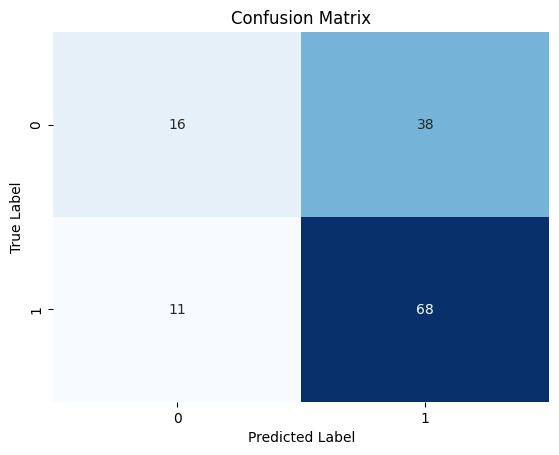

In [53]:
# #Plot Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix with proper labels
conf_mat = confusion_matrix(y1_test, pred_testX1_rf)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Text(0.5, 1.0, 'ROC Curve')

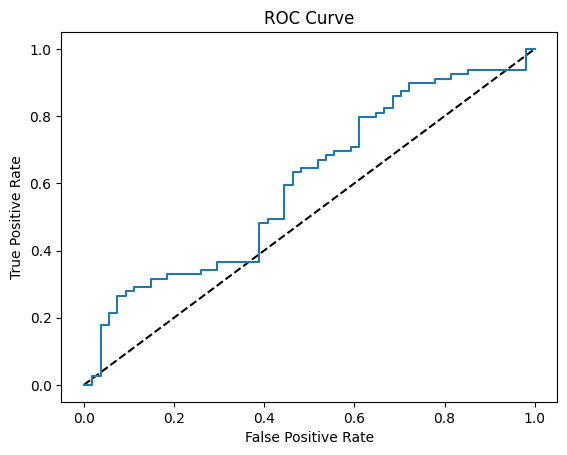

In [55]:
# Plot ROC Curve
from sklearn.metrics import roc_curve

# Get predicted probabilities
y1_pred_prob = rf_final1.predict_proba(X1_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y1_test, y1_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')


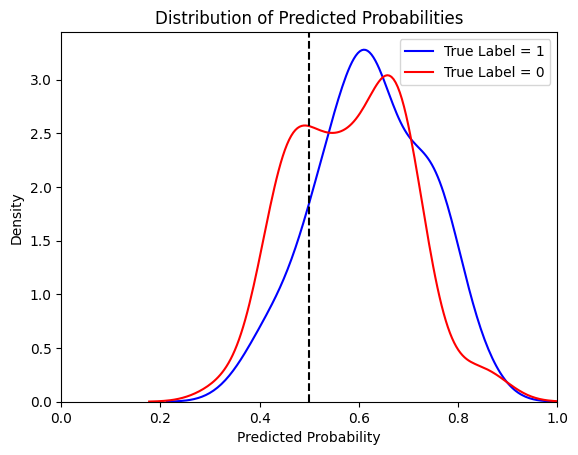

In [59]:
# Plot Distribution of Predicted Probabilities
# Predicted probabilities for the positive class
y1_pred_prob_pos = y1_pred_prob[y1_test == 1]
y1_pred_prob_neg = y1_pred_prob[y1_test == 0]

# Plot the predicted probabilities
sns.kdeplot(y1_pred_prob_pos, color='b', label='True Label = 1')
sns.kdeplot(y1_pred_prob_neg, color='r', label='True Label = 0')
plt.axvline(0.5, color='k', linestyle='--')
plt.xlim(0, 1)
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.show()


### Hyperparameter: Grid Search

In [78]:
# Hyperparmeter Tuning - Grid Search 1st Iteration
param_grid1 = {
    'n_estimators': [50, 100, 200, 300, 500, 1000, 1250, 1500, 1750, 2000], # Number of trees in the forest.
    'max_depth': [2, 5, 10, 20, 30, 40],                                    # Maximum depth of each tree.
    'min_samples_split': [2, 5, 10, 20, 30, 35]                             # Minimum number of samples to split a node.
}

# Set up the first GridSearchCV
grid_search = GridSearchCV(model_rf, param_grid1,
                            scoring='roc_auc',
                            refit='roc_auc',
                            cv=7,
                            verbose=2,
                            n_jobs=4)

# Perform the first Grid Search
grid_searchX1_1st = grid_search.fit(X1_train, y1_train)
#grid_searchX2_1st = grid_search.fit(X2_train, y2_train)
#grid_searchX3_1st = grid_search.fit(X3_train, y3_train)
#grid_searchX4_1st = grid_search.fit(X4_train, y4_train)

Fitting 7 folds for each of 360 candidates, totalling 2520 fits


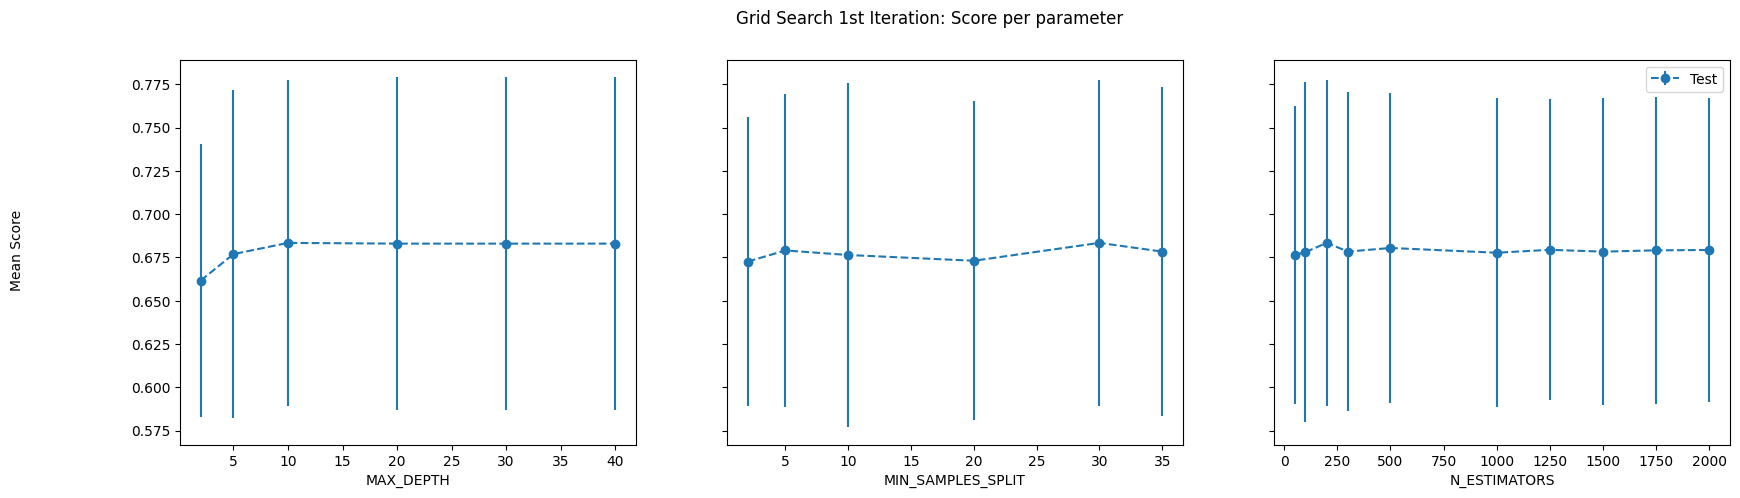

In [80]:
# Results of 1st Grid Search
import numpy as np
import matplotlib.pyplot as plt

def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object (e.g., grid_searchX1_1st).
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results.get('mean_train_score', None)  # In case training scores are not available
    stds_train = results.get('std_train_score', None)

    ## Getting indexes of values per hyper-parameter
    masks = []
    masks_names = list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(np.array(results['param_' + p_k].data) == p_v)

    params = grid.param_grid

    ## Plotting results
    fig, ax = plt.subplots(1, len(params), sharex='none', sharey='all', figsize=(20, 5))
    fig.suptitle('Grid Search 1st Iteration: Score per parameter')
    fig.text(0.04, 0.5, 'Mean Score', va='center', rotation='vertical')

    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        best_params_mask = m.all(axis=0)
        best_index = np.where(best_params_mask)[0]
        x = np.array(params[p])  # Hyperparameter values for current parameter
        y_1 = np.array(means_test[best_index])  # Test scores
        e_1 = np.array(stds_test[best_index])  # Test score std deviations

        if means_train is not None:
            y_2 = np.array(means_train[best_index])  # Training scores
            e_2 = np.array(stds_train[best_index])  # Training score std deviations
            ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='Test')
            ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^', label='Train')
        else:
            ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='Test')

        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

plot_search_results(grid_searchX1_1st)


In [81]:
# Refined Grid
refined_param_grid_X1 = {
    'n_estimators': [300, 400, 500, 600, 700, 800, 900, 1000],  # Narrowed based on the initial results
    'max_depth': list(range(4, 11)),
    'min_samples_split': list(range(10, 21))
}

In [82]:
# Hyperparmeter Tuning - Grid Search 2nd Iteration
refined_grid_search = GridSearchCV(model_rf, param_grid = refined_param_grid_X1,
                                   scoring='roc_auc',
                                   refit='roc_auc',
                                   cv=7,
                                   verbose=2,
                                   n_jobs=4)

grid_searchX1_final = refined_grid_search.fit(X_train, y_train)
joblib.dump(grid_searchX1_final, 'grid_searchX1_final.pkl')

print(f"Best parameters from the Random Search: {grid_searchX1_final.best_params_}")
print(f"Best ROC-AUC score from the Random Search: {grid_searchX1_final.best_score_}")

Fitting 7 folds for each of 616 candidates, totalling 4312 fits


c:\Users\chanho\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters from the Random Search: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 700}
Best F1 score from the Random Search: 0.6695858633358635


In [31]:
# Fit Final Model with Tuned Hyperparameters
best_params = grid_searchX1_final.best_params_
rf_final1 = RandomForestClassifier(**best_params, random_state=666)

rf_final1.fit(X1_train, y1_train)

# Predict on the test set
pred_testX1_rf = rf_final1.predict(X1_test)

# Evaluate the model using appropriate classification metrics
print(f"Accuracy: {accuracy_score(y1_test, pred_testX1_rf)}")
print(f"F1 Score: {f1_score(y1_test, pred_testX1_rf)}")
print(f"ROC AUC Score: {roc_auc_score(y1_test, pred_testX1_rf)}")


Accuracy: 0.6165413533834586
F1 Score: 0.7213114754098361
ROC AUC Score: 0.5658696671354899


## XGBoost

In [36]:
learning_rate_full = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]

n_estimators_full=[10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

max_depth_full=list(range(5,21))


In [39]:
model_xgb = GradientBoostingClassifier(random_state=666)

distributions = dict(n_estimators = n_estimators_full,
                     max_depth = max_depth_full, 
                     learning_rate = learning_rate_full)

clf_xgb = RandomizedSearchCV(model_xgb, distributions, 
                             n_iter=100,
                             verbose=2,
                             n_jobs=4,
                             scoring='f1',
                             refit= 'f1',
                             cv=5, 
                             random_state=666)

search_xgb = clf_xgb.fit(X_train, y_train)

print(f"Best parameters from the Random Search: {search_xgb.best_params_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters from the Random Search: {'n_estimators': 300, 'max_depth': 12, 'learning_rate': 0.0001}


In [40]:
# Fit Final Model with Tuned Hyperparameters
best_params = search_xgb.best_params_
xgb_final1 = GradientBoostingClassifier(**best_params, random_state=666)

# Fit the model
xgb_final1.fit(X1_train, y1_train)

# Predict on the test set
pred_test_xgb1 = xgb_final1.predict(X1_test)

# Evaluate the model using appropriate classification metrics
print(f"Accuracy: {accuracy_score(y1_test, pred_test_xgb1)}")
print(f"F1 Score: {f1_score(y1_test, pred_test_xgb1)}")
print(f"ROC AUC Score: {roc_auc_score(y1_test, pred_test_xgb1)}")

Accuracy: 0.5939849624060151
F1 Score: 0.7452830188679245
ROC AUC Score: 0.5


# SHAP Plots

In [42]:
# To be updated